<a href="https://colab.research.google.com/github/jjrico/Trash-Image-Classification/blob/main/Trash_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Trash Image Classification Project

## By: Jeremy Rico
## Timestamp: 29 Sep, 2020 <12:18>

### Description:

This program utilizes tensorflow and keras to create a convolutional neural network to classify different types of trash types. 


The trash types are as follows:
1. Cardboard
2. Glass
3. Metal
4. Paper
5. Plastic
6. Trash (misc.)




# Setup

In [1]:
%%shell
git clone https://github.com/antiplasti/Plastic-Detection-Model.git

Cloning into 'Plastic-Detection-Model'...
remote: Enumerating objects: 115, done.
remote: Total 115 (delta 0), reused 0 (delta 0), pack-reused 115
Receiving objects: 100% (115/115), 42.76 MiB | 42.92 MiB/s, done.
Resolving deltas: 100% (61/61), done.


Data was obtained from public repo found here: https://github.com/antiplasti/Plastic-Detection-Model/blob/master/training_dataset.zip

## Import Libraries

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

## Download and Navigate Dataset

It is recommended to run this program on a cloud computing service such as Google Colab. In order to run it with the training data, drag and drop the training data into the "sample_data" file directory in google colab. Then run the block below.

In [3]:
import os
import zipfile

local_zip = '/content/Plastic-Detection-Model/training_dataset.zip' #location of .zip file
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content/sample_data') # location to be extracted to
zip_ref.close()

The block above will extract the .zip file into the 'sample_data' directory. If you would prefer to run this program on your machine, simply change the directories to match your working directory.

In [4]:
import pathlib
data_dir = pathlib.Path('/content/sample_data/training_dataset') #location of extracted data
print(data_dir)

/content/sample_data/training_dataset


In [5]:
image_count = len(list(data_dir.glob('**/*.jpg')))
print(image_count, "images")

2527 images


## Dataset Example

Image dimensions: 512 x 384


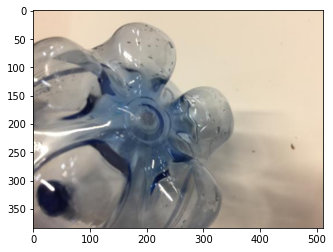

In [6]:
plastic = list(data_dir.glob('plastic/*'))
img = PIL.Image.open(str(plastic[0]))
width, height = img.size
plt.imshow(img)
print("Image dimensions: %d x %d" % (width, height))

# Dataset Manipulation

In [7]:
# Define parameters
batch_size = 32
img_width = 180
img_height = 180
num_classes = 6

For our purposes, it is best to use a validation set. We will divide our training data into 80% training and 20% validation.

##Validation split

In [31]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  color_mode="rgb",
  batch_size=batch_size)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  color_mode="rgb",
  batch_size=batch_size)

# split validation 50/50 with test set

test_ds = val_ds.take(252)
one_obj_test = test_ds.take(1) #grab one test sample before shuffle
#val_ds = val_ds.skip(252)

#print("Using %d files for validation" % validation_ds.shape)
#print("Using %d files for testing" % test_ds.shape)

Found 2527 files belonging to 6 classes.
Using 2022 files for training.
Found 2527 files belonging to 6 classes.
Using 505 files for validation.


### Data Visualization

Below are the first nine images in the training dataset

In [9]:
class_names = train_ds.class_names
print("Class names:", class_names)

Class names: ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


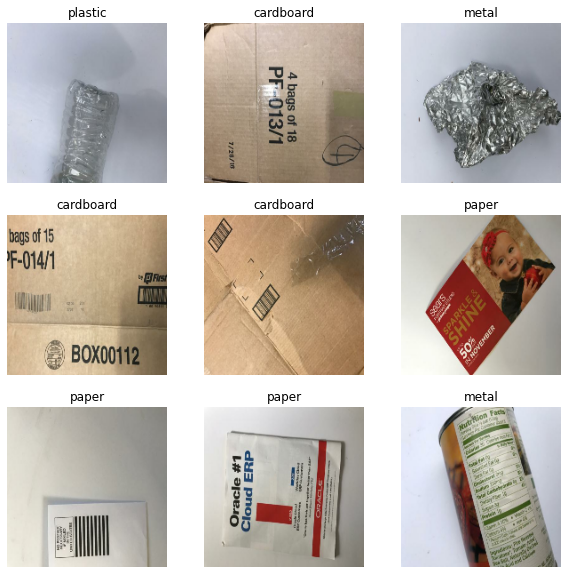

In [12]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [13]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


Image batch is a tensor of size (32, 180, 180, 3). The last dimension represents the three RGB channels.

## Data Configuration

From TensorFlow site:

"Dataset.cache() keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.

Dataset.prefetch() overlaps data preprocessing and model execution while training. "

In [14]:
# Automate buffer size at run time
AUTOTUNE = tf.data.experimental.AUTOTUNE

# use cache for to load images to memory to avoid bottleneck and shuffle for SGD
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Data Augmentation

Since there is a relativley low number of training examples, we will use data augmentation to create multiple augmented data samples from one image. 

In [15]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", input_shape = 
                                                   (img_height, img_width, 3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

Augmentation Example

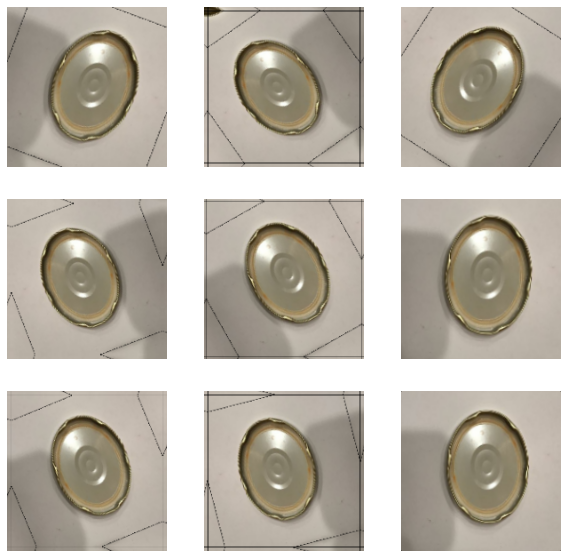

In [16]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

# Model

## Initialization

In [17]:
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

##Define mertrics

In [18]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling (Rescaling)        (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 64)       

## Training

In [19]:
epochs=50
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/50
64/64 [==============================] - 3s 42ms/step - loss: 1.7523 - accuracy: 0.2888 - val_loss: 1.4032 - val_accuracy: 0.4158
Epoch 2/50
64/64 [==============================] - 2s 26ms/step - loss: 1.3890 - accuracy: 0.4402 - val_loss: 1.2641 - val_accuracy: 0.4950
Epoch 3/50
64/64 [==============================] - 2s 26ms/step - loss: 1.2981 - accuracy: 0.4728 - val_loss: 1.2972 - val_accuracy: 0.5010
Epoch 4/50
64/64 [==============================] - 2s 26ms/step - loss: 1.1544 - accuracy: 0.5495 - val_loss: 1.1489 - val_accuracy: 0.5782
Epoch 5/50
64/64 [==============================] - 2s 26ms/step - loss: 1.1253 - accuracy: 0.5682 - val_loss: 1.0784 - val_accuracy: 0.6099
Epoch 6/50
64/64 [==============================] - 2s 26ms/step - loss: 1.0769 - accuracy: 0.5851 - val_loss: 1.0301 - val_accuracy: 0.5941
Epoch 7/50
64/64 [==============================] - 2s 26ms/step - loss: 0.9910 - accuracy: 0.6241 - val_loss: 0.9967 - val_accuracy: 0.6198
Epoch 8/50
64

### Visualize training accuacy and loss

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


Text(0.5, 1.0, 'Training and Validation Accuracy')

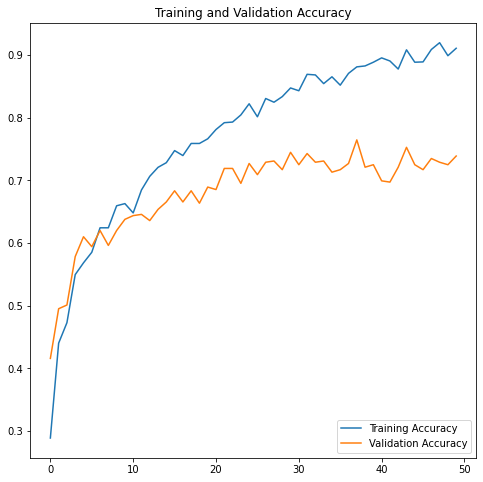

In [20]:
print(history.history.keys())
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']


loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

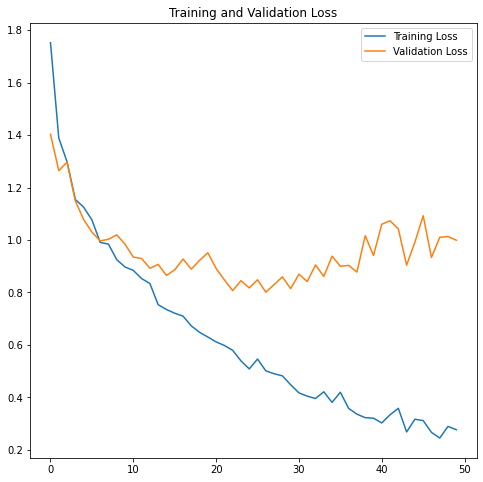

In [21]:
plt.figure(figsize=(8, 8))
#plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#Results

## Single test object

In [22]:
# plt.figure(figsize=(8,8))
# one_obj = test_ds.take(1)
# for images, labels in one_obj:
#   plt.imshow(images[i].numpy().astype("uint8"))
#   plt.title(class_names[labels[i]])
#   plt.axis("off")

Prediction: cardboard 
Confidence: 99.89 %


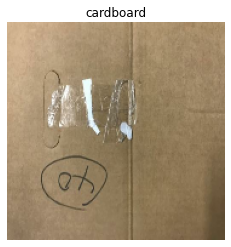

In [43]:
for images, labels in one_obj_test:
  plt.imshow(images[i].numpy().astype("uint8"))
  plt.title(class_names[labels[i]])
  plt.axis("off")

predictions = model.predict(one_obj_test)
score = tf.nn.softmax(predictions[0])

print(
    "Prediction: {} \nConfidence: {:.2f} %"
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

## Test Accuracy

In [39]:
results = model.evaluate(test_ds, batch_size=128)
print("Test loss %.2f\nTest acc: %.2f%%" % (results[0], results[1]*100))

16/16 [==============================] - 1s 33ms/step - loss: 0.9992 - accuracy: 0.7386
Test loss 1.00
Test acc: 73.86%
